# Capstone Project - The Battle of Neighborhoods
# Notebook for final project assignment

## Data Preparation for Population Status of New York
### Finding data from webpage to dataframe

#### Import Pandas, Numpy, BeautifulSoup, Folium and Matplotlib library

In [1]:
# pandas and numpy library
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize

# beautifulsoup library
import requests 
from bs4 import BeautifulSoup

# folium library
!conda install -c conda-forge folium=0.6.0 --yes
import folium
print('Folium installed and imported!')

# matplotlib library
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    numpy-1.14.2               |   py36hdbf6ddf_0         4.0 MB
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    certifi-2018.11.29         |        py36_1000         145 KB  conda-forge
    pandas-0.23.4              |   py36hf8a1672_0        27.8 MB  conda-forge
    folium-0.6.0               |             py_0          51 KB  conda-forge
    altair-2.2.2               |        py36_1001         494 KB  conda-forge
    ca-certificates-2018.

#### Scraping webpage content for New York City population

In [2]:
# set the web link to be opened    
nyc_url='https://en.wikipedia.org/wiki/Demographics_of_New_York_City'
# open with GET method 
resp=requests.get(nyc_url) 
if resp.status_code==200: # http_respone 200 means OK status
    # we need a parser,Python built-in HTML parser is enough . 
    nyc_webpage=BeautifulSoup(resp.text,'html.parser')  
    print("The web page is successfully opened") 
else: 
    print("There is error in opening the web page!") 

The web page is successfully opened


In [3]:
# scrape the require section
# set up heading
df_newyork = pd.DataFrame(columns = ['Borough', 'County', '2017_Population',
                             'Area_mile', 'Area_km',
                             'Population_Density_permile', 'Population_Density_perkm'])

# get population data of New York city from sub-section 
list = nyc_webpage.find_all('td')
t = [None] * 35
idx = 0
j = 0
#print(len(list))
for item in list:
    if (j < 35):
        t[j] = item.text.rstrip().lstrip()
        j+=1
for i in range(0,5):
    df_newyork.loc[i] = [t[i*7], t[i*7+1], int(t[i*7+2].replace(',','')), float(t[i*7+3].replace(',','')),
                        float(t[i*7+4].replace(',','')), int(t[i*7+5].replace(',','')),
                        int(t[i*7+6].replace(',',''))]
df_newyork

,Borough,County,2017_Population,Area_mile,Area_km,Population_Density_permile,Population_Density_perkm
0,Manhattan,New York,1664727,22.83,59.13,72033,27826
1,The Bronx,Bronx,1471160,42.10,109.04,34653,13231
2,Brooklyn,Kings,2648771,70.82,183.42,37137,14649
3,Queens,Queens,2358582,108.53,281.09,21460,8354
4,Staten Island,Richmond,479458,58.37,151.18,8112,3132


#### Prepare the population density data of New York City and display in a choropleth map

##### Get the latitude and longitude values of New York City from webpage

In [4]:
nyc_url='https://latitude.to/articles-by-country/us/united-states/11/new-york-city'
# open with GET method 
resp=requests.get(nyc_url) 
if resp.status_code==200: # http_respone 200 means OK status
    # we need a parser,Python built-in HTML parser is enough . 
    nyc_webpage=BeautifulSoup(resp.text,'html.parser')  
    # get the class="coord DD" for the coordinate
    div = nyc_webpage.find('div', attrs={'class': 'coord DD'})
    coor = div.findChildren()[1].get('value')
    nyc_lat = float(coor.split()[0])
    nyc_long = float(coor.split()[1])
    print('Latitude and longitude values of Upper West Side are {}, {}.'.format(nyc_lat, nyc_long)) 
else: 
    print("There is error in opening the web page!")

Latitude and longitude values of Upper West Side are 40.7166638, -74.0.


In [5]:
# download brough boundary of New York City 
!wget --quiet http://data.beta.nyc//dataset/3bf5fb73-edb5-4b05-bb29-7c95f4a727fc/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90/download/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson -O nyc.json
nyc_geo = r'nyc.json'

print('New Yord City GeoJSON file downloaded!')

New Yord City GeoJSON file downloaded!


In [6]:
# prepare a choropleth map centered around New York City
nyc_map = folium.Map(location=[nyc_lat, nyc_long], zoom_start=10,  tiles='Mapbox Bright')

# generate choropleth map
nyc_map.choropleth(
    geo_data=nyc_geo,
    data=df_newyork,
    columns=['Borough', 'Population_Density_perkm'],
    key_on='feature.properties.borough',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population Density of New York City Boroughs'
)

# display NYC choropleth map
nyc_map

##### Prepare a bar chart to graphically understand the population density in New York City

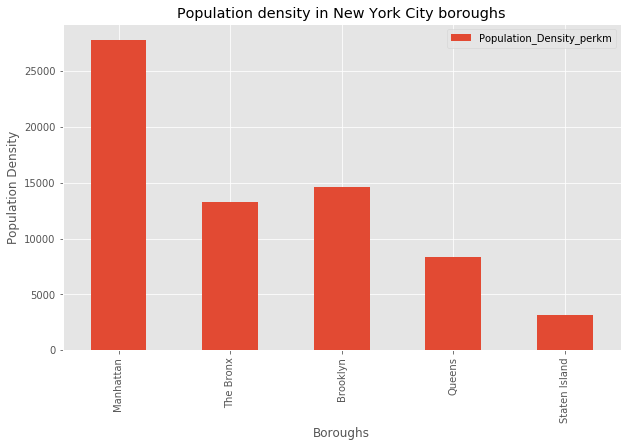

In [7]:
# prepare the dataset
df_nycden = df_newyork.copy()
columns = ['County', '2017_Population', 'Area_mile', 'Area_km', 'Population_Density_permile']
df_nycden.drop(columns, inplace=True, axis=1)
df_nycden.set_index('Borough', inplace=True)

# plot data
df_nycden.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Boroughs') # add x-label to the plot
plt.ylabel('Population Density') # add y-label to the plot
plt.title('Population density in New York City boroughs')

plt.show()

### It is obvious that Manhattan get the highest population density
#### Then will turn our focus on further study Manhattan area

##### Getting the population csv data for Manhattan neighborhoods from webpage
##### data.cityofnewyork.us/City-Government/Manhattan-populations-by-neighborhood/8m6s-esnp

In [8]:
# import the population csv data
    
!wget --quiet -O man_neigh_pop.csv "https://drive.google.com/uc?authuser=0&id=1oteKFvh4k9o3aH3gbdLNC0Oq1F0-BI0h&export=download"

df_man = pd.read_csv('man_neigh_pop.csv')
df_man.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Manhattan,2010,61,MN01,Marble Hill-Inwood,46746
1,Manhattan,2010,61,MN03,Central Harlem North-Polo Grounds,75282
2,Manhattan,2010,61,MN04,Hamilton Heights,48520
3,Manhattan,2010,61,MN06,Manhattanville,22950
4,Manhattan,2010,61,MN09,Morningside Heights,55929


#### Display the population data in a map
##### Prepare a choropleth map centered around Manhattan

##### Get the neighborhood's latitude and longitude values of Manhattan

In [9]:
man_url='https://latitude.to/articles-by-country/us/united-states/160/manhattan'
# open with GET method 
resp=requests.get(man_url) 
if resp.status_code==200: # http_respone 200 means OK status
    # we need a parser,Python built-in HTML parser is enough . 
    man_webpage=BeautifulSoup(resp.text,'html.parser')  
    # get the class="coord DD" for the coordinate
    div = man_webpage.find('div', attrs={'class': 'coord DD'})
    coor = div.findChildren()[1].get('value')
    man_lat = float(coor.split()[0])
    man_long = float(coor.split()[1])
    print('Latitude and longitude values of Manhattan are {}, {}.'.format(man_lat, man_long)) 
else: 
    print("There is error in opening the web page!") 

Latitude and longitude values of Manhattan are 40.723663772, -73.989829374.


In [10]:
# download brough boundary of Manhattan
!wget --quiet -O man.json "https://drive.google.com/uc?authuser=0&id=1NIduULTbs3o73tlQV_Y2xkyQQQKs29PV&export=download"
man_geo = r'man.json'

print('Manhattan GeoJSON file downloaded!')

Manhattan GeoJSON file downloaded!


In [11]:
# prepare a choropleth map centered around Manhattan
import json

man_map = folium.Map(location=[man_lat, man_long], zoom_start=11,  tiles='Mapbox Bright')
# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
man_map.choropleth(
    geo_data=man_geo,
    data=df_man,
    columns=['NTA Code', 'Population'],
    key_on='feature.properties.ntacode',
    fill_color='YlOrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Population of Manhattan Neighborhoods'
)
man_map

##### Prepare a bar chart to graphically understand the population distribution

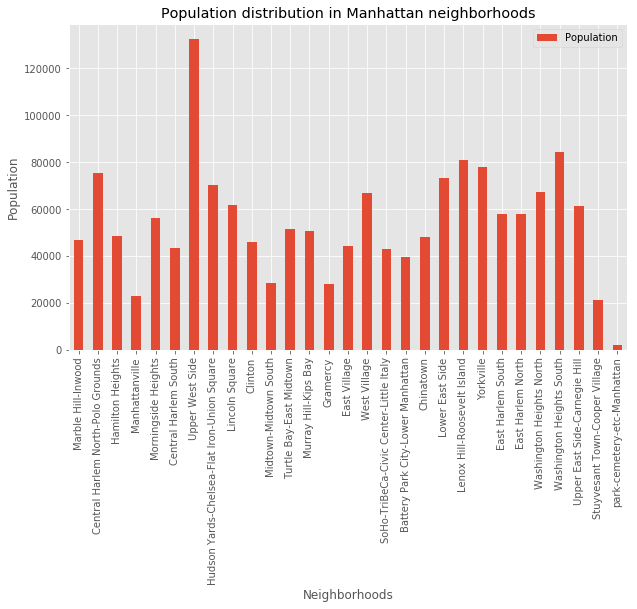

In [12]:
# prepare the dsataset
df_manpop = df_man.copy()
columns = ['Year', 'FIPS County Code', 'Borough', 'NTA Code']
df_manpop.drop(columns, inplace=True, axis=1)
df_manpop.set_index('NTA Name', inplace=True)

# plot data
df_manpop.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Neighborhoods') # add x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Population distribution in Manhattan neighborhoods')

plt.show()

### From the population information of Manhattan neighborhoods, the restaurant will target to locate at Upper West Side (MN12) of Manhattan which shows the highest potential customers there.

### Using FOURSQUAR to find out the most favious food and place that Upper West Side residence love to have
##### Define Foursquare Credentials

In [13]:
CLIENT_ID = 'C51V25TSOEAIU2DQRLPD1OFV4Z3FPI4V4OMGLF4SZBSXZQMV'
CLIENT_SECRET = 'TQI1WB4CUJKIAZA3W0NU0BJCR2WDZ2SI1FKQN2MTKCBQGMI2'
VERSION = '20180605' # Foursquare API version

print('The credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

The credentails:
CLIENT_ID: C51V25TSOEAIU2DQRLPD1OFV4Z3FPI4V4OMGLF4SZBSXZQMV
CLIENT_SECRET:TQI1WB4CUJKIAZA3W0NU0BJCR2WDZ2SI1FKQN2MTKCBQGMI2


##### Get the neighborhood's latitude and longitude values of Upper West Side from webpage

In [14]:
# access htps://latitude.to site to retrieve the coordinate of Upper West Side 
uws_url='https://latitude.to/articles-by-country/us/united-states/2146/upper-west-side'
# open with GET method 
resp=requests.get(uws_url) 
if resp.status_code==200: # http_respone 200 means OK status
    # we need a parser,Python built-in HTML parser is enough . 
    uws_webpage=BeautifulSoup(resp.text,'html.parser')  
    # get the class="coord DD" for the coordinate
    div = uws_webpage.find('div', attrs={'class': 'coord DD'})
    coor = div.findChildren()[1].get('value')
    uws_lat = float(coor.split()[0])
    uws_long = float(coor.split()[1])
    print('Latitude and longitude values of Upper West Side are {}, {}.'.format(uws_lat, uws_long)) 
else: 
    print("There is error in opening the web page!") 

Latitude and longitude values of Upper West Side are 40.785496858, -73.971829446.


##### Define a function for extracting category of found venues

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Get the top 100 food venues that are in Upper West Side within a radius of 500 meters.

In [16]:
LIMIT = 100
radius = 500 # meters
query = 'Top'
# create URL
#https://foursquare.com/explore?mode=url&ne=22.291598%2C114.159075&q=Food&sw=22.279189%2C114.141523
#ENDPOINT: venues/explore 
#PARAMETERS: near = San Francisco; query = Tea Shop
url = 'https://api.foursquare.com/v2/venues/explore?&query={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    query,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    uws_lat, 
    uws_long, 
    radius, 
    LIMIT)
food_results = requests.get(url).json()

##### Use get_category_type function from the Foursquare lab to form food venue data

In [17]:
# form the food venue dataframe
venues = food_results['response']['groups'][0]['items']
    
food_venues = json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
food_venues = food_venues.loc[:, filtered_columns]

# filter the category for each row
food_venues['venue.categories'] = food_venues.apply(get_category_type, axis=1)

# clean columns
food_venues.columns = [col.split(".")[-1] for col in food_venues.columns]

# get which food venues categories group
grouped = food_venues.groupby('categories')['categories'].count().reset_index(name="count")

df_food = pd.DataFrame(grouped)
df_food.set_index('categories', inplace=True)
df_food.head()

,count
categories,
Bagel Shop,1
Bar,1
Breakfast Spot,1
Café,1
Coffee Shop,2


##### Prepare a bar chart to graphically understand the food place distribution

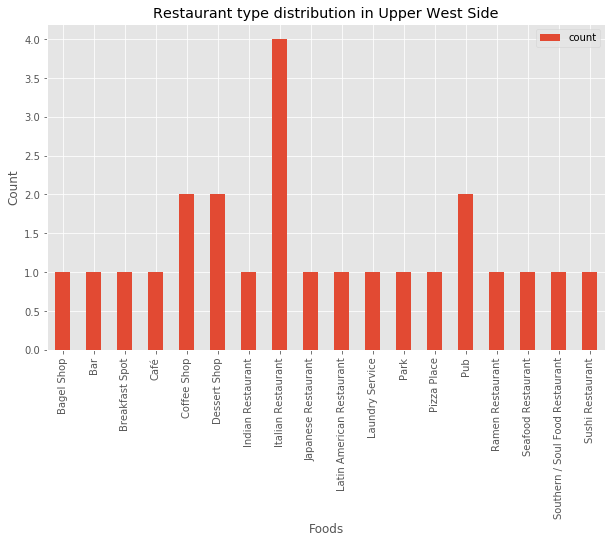

In [18]:
# plot data
df_food.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Foods') # add x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Restaurant type distribution in Upper West Side')

plt.show()

#### Get the top 100 fun venues that are in Upper West Side within a radius of 500 meters.

In [19]:
LIMIT = 100
radius = 500 # meters
query = 'Fun'
# create URL
#https://foursquare.com/explore?mode=url&ne=22.291598%2C114.159075&q=Food&sw=22.279189%2C114.141523
#ENDPOINT: venues/explore 
#PARAMETERS: near = San Francisco; query = Tea Shop
url = 'https://api.foursquare.com/v2/venues/explore?&query={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    query,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    uws_lat, 
    uws_long, 
    radius, 
    LIMIT)
fun_results = requests.get(url).json()

##### Use get_category_type function from the Foursquare lab to form fun venue data

In [20]:
# form the food venue dataframe
venues = fun_results['response']['groups'][0]['items']
fun_venues = json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
fun_venues = fun_venues.loc[:, filtered_columns]

# filter the category for each row
fun_venues['venue.categories'] = fun_venues.apply(get_category_type, axis=1)

# clean columns
fun_venues.columns = [col.split(".")[-1] for col in fun_venues.columns]

# get which fun venues categories group
grouped = fun_venues.groupby('categories')['categories'].count().reset_index(name="count")

df_fun = pd.DataFrame(grouped)
df_fun.set_index('categories', inplace=True)
df_fun.head()

,count
categories,
Art Gallery,1
Bar,1
Dance Studio,3
Dog Run,1
Historic Site,3


##### Prepare a bar chart to graphically understand the fun area distribution

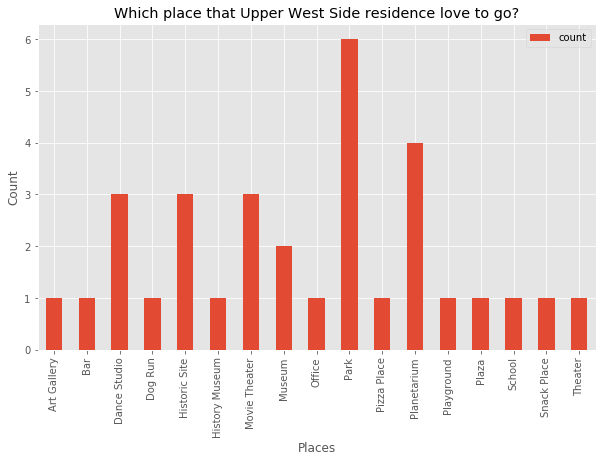

In [21]:
# plot data
df_fun.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Places') # add x-label to the plot
plt.ylabel('Count') # add y-label to the plot
plt.title('Which place that Upper West Side residence love to go?')

plt.show()

## Study Summary

### From the previous studies, there are some findings that help to make decision
#### 1. Manhattan have the highest population density throughout New York City.
#### 2. Upper West Side being the neighborhood area that has the highest population.
#### 3. Italian food is the most favor food that Upper West Side people like.
#### 4. Going to park is the most interest place that Upper West Side people like to visit.

## Conclusion
### It is suggested to open an Italian restaurant with the decoration theme of mimic a park environment will likely to fit the citizen taste.